In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi']=100
sns.set_style('darkgrid')

### Loading the dataset 

In [2]:
df=pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
df.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


### EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [4]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [5]:
df.shape

(42, 2)

array([[<Axes: title={'center': 'Sales'}>]], dtype=object)

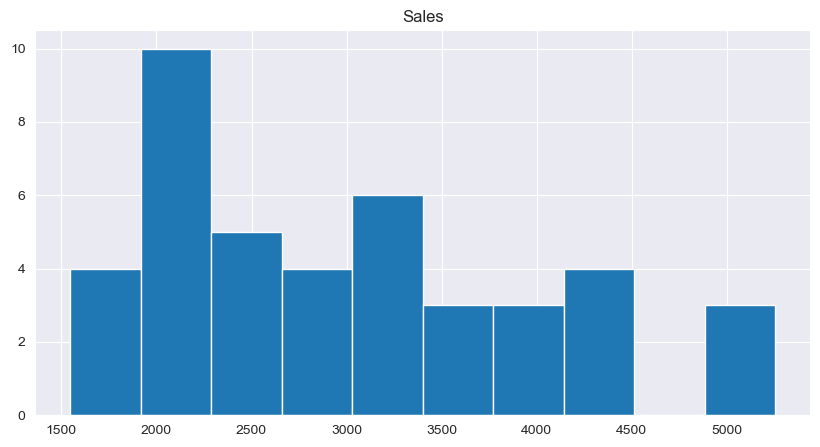

In [6]:
df.hist()

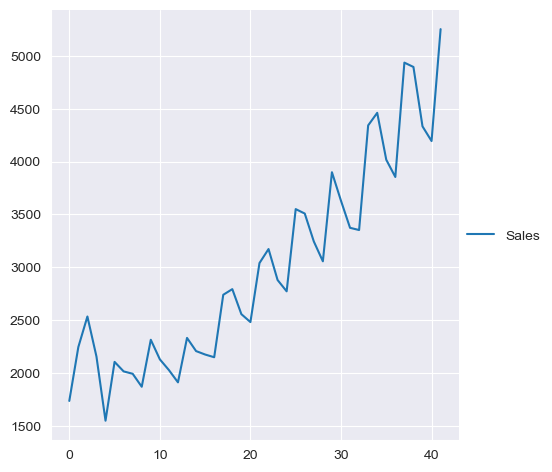

In [7]:
sns.relplot(data=df, kind="line")

In [8]:
quarter=['Q1','Q2','Q3','Q4']
n=df['Quarter'][0]
n[0:2]

df['quarter']=0

In [9]:
for i in range(42):
    n=df['Quarter'][i]
    df['quarter'][i]=n[0:2]

In [10]:
dummy=pd.DataFrame(pd.get_dummies(df['quarter']))

In [11]:
coco=pd.concat((df,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [12]:
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales

### Splitting the data 

In [13]:
train=coco.head(38)
test=coco.tail(4)

In [14]:
# Apply different forecasting methods

# 1) linear model

linear_model=smf.ols('Sales~t',data=train).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(test['t'])))
rmse_linear=np.sqrt(mean_squared_error(test['Sales'],pred_linear))
rmse_linear

591.5532957223963

In [15]:
#2) Exponential model

exp=smf.ols('log_Sales~t',data=train).fit()
pred_exp=pd.Series(exp.predict(pd.DataFrame(test['t'])))
rmse_exp=np.sqrt(mean_squared_error(test['Sales'],pred_exp))
rmse_exp

4679.904945202525

In [16]:
# 3)Quadratic model

quad=smf.ols('Sales~t+t_square',data=train).fit()
pred_quad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmse_quad=np.sqrt(mean_squared_error(test['Sales'],pred_quad))
rmse_quad

475.56183518315095

In [17]:
# 4)Additive seasonality

add_sea=smf.ols('Sales~Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea=pd.Series(add_sea.predict(test[['Q1','Q2','Q3','Q4']]))
rmse_add_sea=np.sqrt(mean_squared_error(test['Sales'],pred_add_sea))
rmse_add_sea

1860.0238154547283

In [18]:
# 5)Additive Seasonality with Quadratic trend

add_sea_que=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_add_sea_que=pd.Series(add_sea_que.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_add_sea_que=np.sqrt(mean_squared_error(test['Sales'],pred_add_sea_que))
rmse_add_sea_que

301.73800719352977

In [19]:
# 6)Multiplicative Seasonality

mul_sea=smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
pred_mult_sea=pd.Series(mul_sea.predict(test[['t','Q1','Q2','Q3','Q4']]))
rmse_mult_sea=np.sqrt(mean_squared_error(test['Sales'],pred_mult_sea))
rmse_mult_sea

4679.899785143725

In [20]:
# compare the results of all models

data={'MODEL':pd.Series(['rmse_linear','rmse_exp','rmse_quad','rmse_add_sea','rmse_add_sea_que','rmse_mult_sea']),
     'RMSE_values':pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_que,rmse_mult_sea])
     }

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_values'])

,MODEL,RMSE_values
4,rmse_add_sea_que,301.738007
2,rmse_quad,475.561835
0,rmse_linear,591.553296
3,rmse_add_sea,1860.023815
5,rmse_mult_sea,4679.899785
1,rmse_exp,4679.904945


#### Conclusion: so the additive seasonality with quadratic trend model gives the least rmse value that is 301

### Moving Average

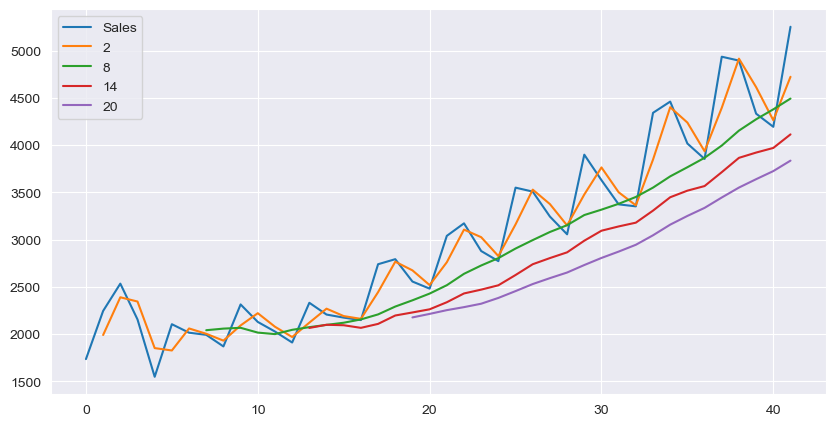

In [21]:
df['Sales'].plot()
df['Sales'].rolling(10).mean().plot

for i in range(2,24,6):
    df['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend()